In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import openpyxl
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from calendar import monthrange
import numpy as np
from scipy.optimize import root_scalar
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def extract_hyperlinks_and_scrape(file_path, column_name):
    # load in data
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active  # activate sheet

    data = [list(row) for row in sheet.iter_rows(min_row=2, values_only=True)]

    headers = [cell for cell in next(sheet.iter_rows(min_row=1, max_row=1, values_only=True))]
    full_df = pd.DataFrame(data, columns=headers)

    col_index = headers.index(column_name)

    # Extract hyperlinks here
    hyperlinks = []
    for row in sheet.iter_rows(min_row=2, min_col=col_index + 1, max_col=col_index + 1):  
        cell = row[0]
        if cell.hyperlink: 
            hyperlinks.append(cell.hyperlink.target)
        else:
            hyperlinks.append(None)  
    full_df['hyperlink'] = hyperlinks

    # Scrape the data for required entries
    
    scraped_data = []
    for _, row in full_df.iterrows():
        if pd.notna(row['hyperlink']):
            try:
                # GET request
                response = requests.get(row['hyperlink'])
                response.raise_for_status()
                soup = BeautifulSoup(response.text, 'html.parser')


                    # on webpage, find table
                table = soup.find('table', class_='table table--no-vertical-border')
                bond_data = {}
                current_group = None

                for row in table.find_all('tr', class_='table__tr'):
                    cells = row.find_all('td')
                    if len(cells) == 2:
                        key = cells[0].get_text(strip=True)
                        value = cells[1].get_text(strip=True)
                        bond_data[key] = value
                    elif len(cells) == 1 and 'colspan' in cells[0].attrs:
                    
                        current_group = cells[0].get_text(strip=True)
                        bond_data[current_group] = {}

                    # store data
                scraped_data.append({
                    'ISIN': bond_data.get('ISIN', ''),
                    'Name': bond_data.get('Name', ''),
                    'Coupon': bond_data.get('Coupon', ''),
                    'Issue Date': bond_data.get('Issue Date', ''),
                    'Maturity Date': bond_data.get('Maturity Date', '')
                })
            except Exception as e:
                # error flagging
                print(f"Error scraping {row['hyperlink']}: {e}")
                scraped_data.append({'ISIN': '', 'Name': '', 'Coupon': '', 'Issue Date': '', 'Maturity Date': ''})
        else:
            scraped_data.append({'ISIN': '', 'Name': '', 'Coupon': '', 'Issue Date': '', 'Maturity Date': ''})

    scraped_df = pd.DataFrame(scraped_data)
    df = pd.concat([full_df[['hyperlink','date','Yield','Bid','Ask']], scraped_df], axis=1)

    return df


# Input file path and column name
file_path = 'bond_data.xlsx'  
col_name = 'Name'  

# dataframe with scraped data
scraped_df = extract_hyperlinks_and_scrape(file_path, col_name)



# Process data

In [26]:

df = scraped_df.copy()


for column in ['Yield', 'Bid', 'Ask']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# convert coupon percentage strings to decimals
df['Coupon'] = df['Coupon'].str.rstrip('%').astype(float) / 100

# datetime conversion
date_columns = ['date', 'Issue Date', 'Maturity Date']
for column in date_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce')

df['Name'] = df.apply(
    lambda row: f"CAN {row['Coupon'] * 100:.2f} {row['Maturity Date'].strftime('%b%y')}" 
    if pd.notnull(row['Coupon']) and pd.notnull(row['Maturity Date']) else None, 
    axis=1
)
# midpoint averaged bid and ask
df['midpoint'] = (df['Bid'] + df['Ask']) /2


print(df.head())

                                           hyperlink       date   Yield  \
0  https://markets.businessinsider.com/bonds/cana... 2025-01-06  0.0309   
1  https://markets.businessinsider.com/bonds/cana... 2025-01-06  0.0286   
2  https://markets.businessinsider.com/bonds/cana... 2025-01-06  0.0281   
3  https://markets.businessinsider.com/bonds/cana... 2025-01-06  0.0311   
4  https://markets.businessinsider.com/bonds/cana... 2025-01-06  0.0300   

     Bid    Ask          ISIN            Name  Coupon Issue Date  \
0  99.66  99.68  CA135087D507  CAN 2.25 Jun25  0.0225 2014-06-30   
1  98.16  98.19  CA135087E679  CAN 1.50 Jun26  0.0150 2015-07-21   
2  95.84  95.93  CA135087F825  CAN 1.00 Jun27  0.0100 2016-08-03   
3  99.71  99.73  CA135087K528  CAN 1.25 Mar25  0.0125 2019-10-11   
4  98.41  98.43  CA135087K940  CAN 0.50 Sep25  0.0050 2020-04-03   

  Maturity Date  midpoint  
0    2025-06-01    99.670  
1    2026-06-01    98.175  
2    2027-06-01    95.885  
3    2025-03-01    99.720  


In [27]:

df[
    (df['date'] == datetime(2025,1,10)) &
    (df['Maturity Date'] <= df['date'].min() + timedelta(days=(7 * 365 + 30)))  # 5 years and 1 month
].sort_values('Maturity Date')


# scraped_df[scraped_df['date'] == datetime(2025,1,10)]

,hyperlink,date,Yield,Bid,Ask,ISIN,Name,Coupon,Issue Date,Maturity Date,midpoint
184,https://markets.businessinsider.com/bonds/cana...,2025-01-10,NaN,100.00,100.07,CA135087P659,CAN 3.75 Feb25,0.03750,2022-11-02,2025-02-01,100.035
173,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0326,99.73,99.75,CA135087K528,CAN 1.25 Mar25,0.01250,2019-10-11,2025-03-01,99.740
191,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0320,99.61,99.68,CA135087N340,CAN 1.50 Apr25,0.01500,2022-01-24,2025-04-01,99.645
195,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0320,99.61,99.68,CA135087N340,CAN 1.50 Apr25,0.01500,2022-01-24,2025-04-01,99.645
187,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0305,100.16,100.23,CA135087Q319,CAN 3.75 May25,0.03750,2023-02-10,2025-05-01,100.195
179,https://markets.businessinsider.com/bonds/9_00...,2025-01-10,0.0304,102.26,102.36,CA135087VH40,CAN 9.00 Jun25,0.09000,1994-08-02,2025-06-01,102.310
185,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0312,99.64,99.74,CA135087D507,CAN 2.25 Jun25,0.02250,2014-06-30,2025-06-01,99.690
182,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0304,100.25,100.26,CA135087Q640,CAN 3.50 Aug25,0.03500,2023-05-12,2025-08-01,100.255
174,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0303,98.39,98.47,CA135087K940,CAN 0.50 Sep25,0.00500,2020-04-03,2025-09-01,98.430
192,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0301,99.99,100.00,CA135087P246,CAN 3.00 Oct25,0.03000,2022-07-25,2025-10-01,99.995


# Filter the pre-selected bonds

In [28]:
# list of selected bonds
bond_names = [
    "CAN 1.25 Mar25", "CAN 0.50 Sep25", 
    "CAN 0.25 Mar26", "CAN 1.00 Sep26", "CAN 1.25 Mar27", "CAN 2.75 Sep27", "CAN 3.50 Mar28",
    "CAN 3.25 Sep28", "CAN 4.00 Mar29", "CAN 3.50 Sep29", "CAN 2.75 Mar30"
]

# filter the dataframe for those bonds
filtered_df = df[df['Name'].isin(bond_names)]

grouped_midpoint_counts = filtered_df.groupby('Name')['midpoint'].apply(lambda x: x.notnull().sum())

print(grouped_midpoint_counts)

# filtered_df[filtered_df['midpoint'].isnull()]

Name
CAN 0.25 Mar26    11
CAN 0.50 Sep25    11
CAN 1.00 Sep26    12
CAN 1.25 Mar25    11
CAN 1.25 Mar27    13
CAN 2.75 Mar30    11
CAN 2.75 Sep27    11
CAN 3.25 Sep28    11
CAN 3.50 Mar28    11
CAN 3.50 Sep29    11
CAN 4.00 Mar29    11
Name: midpoint, dtype: int64


In [29]:


def calculate_accrued_interest(last_coupon_date, cur_date, cpn):
    """
    Calculate the accrued interest based on the number of days between the last coupon date and the current date.

    Args:
        last_coupon_date (datetime): The date of the last coupon payment.
        cur_date (datetime): The current date.
        cpn (float): The annual coupon payment.

    Returns:
        float: Accrued interest.
    """

    # days between the last coupon date and the current date
    n = (cur_date - last_coupon_date).days

    #  accrued interest using n/365 * cpn
    accrued_interest = (n / 365) * cpn

    return accrued_interest


def get_last_cpn_date(cur_date, maturity_date,issue_date):
    """
    Find the last coupon payment date by moving back in 6-month intervals from the maturity date.
    Explicitly set the day number and handle cases where the day does not exist in the resulting month.

    Args:
        cur_date (datetime): Current date.
        maturity_date (datetime): Maturity date of the bond.

    Returns:
        datetime: Last coupon payment date.
    """

    # Start with the maturity date
    last_coupon_date = maturity_date
    
    while last_coupon_date > cur_date:
        # Extract the day number
        target_day = last_coupon_date.day

        # Move back 6 months
        year = last_coupon_date.year
        month = last_coupon_date.month - 6
        if month <= 0:  # overflow, get previous year
            year -= 1
            month += 12

        # Get the last day of the resulting month
        _, last_day_of_month = monthrange(year, month)

        # Use same day, otherwise use the last day of the month
        adjusted_day = min(target_day, last_day_of_month)
        last_coupon_date = last_coupon_date.replace(year=year, month=month, day=adjusted_day)
    
    if last_coupon_date < issue_date:
        return issue_date

    return last_coupon_date

def generate_coupon_dates(cur_date, maturity_date):
    """
    Generate all future coupon payment dates stopping before cur_date.
    """
    coupon_dates = []
    last_coupon_date = maturity_date

    while last_coupon_date > cur_date:
        coupon_dates.append(last_coupon_date)

        # Extract the day number
        target_day = last_coupon_date.day

        # Move back 6 months
        year = last_coupon_date.year
        month = last_coupon_date.month - 6
        if month <= 0:  
            year -= 1
            month += 12

        #  months with fewer days
        while True:
            try:
                last_coupon_date = datetime(year, month, target_day)
                break
            except ValueError:  # Day doesn't exist in this month, take the previous
                target_day -= 1

    coupon_dates.reverse()  
    return coupon_dates



def calculate_ytm(clean_price, cur_date, maturity_date, cpn, issue_date, face_value=100):
    """
    Calculate Yield to Maturity (YTM) using iterative techniques.
    Returns both continuous and semi-annual discounting YTM.
    """
    # project future coupon payment dates
    coupon_dates = generate_coupon_dates(cur_date, maturity_date)

    last_coupon_date = get_last_cpn_date(cur_date, maturity_date,issue_date)

    dirty_price = clean_price + calculate_accrued_interest(last_coupon_date, cur_date, cpn*face_value)
    
    # Calculate cash flows: periodic coupon payments and face value
    cash_flows = [(cpn/2)*face_value] * (len(coupon_dates) - 1) + [face_value*(cpn/2) + face_value]
    

    #  years to apyment ( 365-day convention)
    time_periods = [(date - cur_date).days / 365 for date in coupon_dates]
    # print(cash_flows)
    # print(time_periods)
    #  semi annual discounting helper function
    def bond_price_semi_annual(ytm):
        return sum(cf / (1 + (ytm / 2)) ** (2 * t) for cf, t in zip(cash_flows, time_periods))

    # continuous discounting helper function
    def bond_price_continuous(ytm):
        return sum(cf * np.exp(-ytm * t) for cf, t in zip(cash_flows, time_periods))

    # solve for ytm using scipy root_scalar
    def solve_ytm(func):
        """
        
        """
        # define the bond price equation, to be passed into 
        def equation(ytm):
            return func(ytm) - dirty_price

        # Use root_scalar to find the YTM
        result = root_scalar(equation, bracket=[0.0001, 1], method='brentq')  
        if result.converged:
            return result.root
        else:
            result = np.nan
            print("YTM calculation did not converge.")

    # find the root (YTM)
    ytm_semi_annual = solve_ytm(bond_price_semi_annual)
    ytm_continuous = solve_ytm(bond_price_continuous)

    return ytm_semi_annual, ytm_continuous





In [30]:
def calculate_yield_df(df,scheme = 'continuous',face_value = 100):
    if scheme == 'continuous':
        i = 1
    elif scheme == 'semi-annual':
        i = 0
    else:
        print('Invalid scheme')
    
    df['ytm'] = df.apply(
    lambda row: calculate_ytm(
        row['midpoint'], row['date'], row['Maturity Date'],
        row['Coupon'], row['Issue Date'], face_value
    )[i],  # 
    axis=1
        )

    return df




In [31]:
calculate_ytm(99.72, datetime(2025,1,6), datetime(2025,3,1), 0.0125, datetime(2019,10,11), face_value=100)

calculate_ytm(97.03, datetime(2025,1,6), datetime(2026,9,1), 0.0100, datetime(2021,4,16), face_value=100)

filtered_df_yields = calculate_yield_df(filtered_df)

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\524097719.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ytm'] = df.apply(


In [32]:
filtered_df_yields.head(15)

,hyperlink,date,Yield,Bid,Ask,ISIN,Name,Coupon,Issue Date,Maturity Date,midpoint,ytm
3,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0311,99.71,99.73,CA135087K528,CAN 1.25 Mar25,0.0125,2019-10-11,2025-03-01,99.720,0.031650
4,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0300,98.41,98.43,CA135087K940,CAN 0.50 Sep25,0.0050,2020-04-03,2025-09-01,98.420,0.029422
5,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0292,96.98,96.99,CA135087L518,CAN 0.25 Mar26,0.0025,2020-10-09,2026-03-01,96.985,0.029196
6,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0287,97.02,97.04,CA135087L930,CAN 1.00 Sep26,0.0100,2021-04-16,2026-09-01,97.030,0.028327
7,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0288,96.62,96.70,CA135087M847,CAN 1.25 Mar27,0.0125,2021-10-15,2027-03-01,96.660,0.028461
9,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0288,99.63,99.72,CA135087N837,CAN 2.75 Sep27,0.0275,2022-05-13,2027-09-01,99.675,0.028570
25,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0290,101.18,101.41,CA135087Q491,CAN 3.25 Sep28,0.0325,2023-04-21,2028-09-01,101.295,0.028509
27,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0295,102.32,102.45,CA135087R895,CAN 3.50 Sep29,0.0350,2024-04-08,2029-09-01,102.385,0.029240
32,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0297,98.81,98.81,CA135087S471,CAN 2.75 Mar30,0.0275,2024-10-03,2030-03-01,98.810,0.030296
33,https://markets.businessinsider.com/bonds/cana...,2025-01-06,0.0292,104.16,104.29,CA135087Q988,CAN 4.00 Mar29,0.0400,2023-10-13,2029-03-01,104.225,0.028916


In [33]:
def generate_interpolated_ytm_curve(date, years, data):
    #  grab specified date
    filtered_data = data[data['date'] == date].copy()
    
    #  years to maturity
    filtered_data['maturity_years'] = (filtered_data['Maturity Date'] - filtered_data['date']).dt.days / 365.0
    

    filtered_data = filtered_data.dropna(subset=['maturity_years', 'ytm'])
    
    filtered_data = filtered_data.sort_values(by='maturity_years')
    
    interpolated_df = pd.DataFrame({'date': date, 'maturity_years': years})
    
    # linear interpolation
    interpolated_df['ytm'] = np.interp(
        interpolated_df['maturity_years'],
        filtered_data['maturity_years'],
        filtered_data['ytm'],
        left=np.nan,  
        right=np.nan
    )
    
    return interpolated_df


generate_interpolated_ytm_curve(datetime(2025,1,20), [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], filtered_df_yields)

,date,maturity_years,ytm
0,2025-01-20,0.5,0.029618
1,2025-01-20,1.0,0.029574
2,2025-01-20,1.5,0.028901
3,2025-01-20,2.0,0.028911
4,2025-01-20,2.5,0.029119
5,2025-01-20,3.0,0.028993
6,2025-01-20,3.5,0.029134
7,2025-01-20,4.0,0.029605
8,2025-01-20,4.5,0.030081
9,2025-01-20,5.0,0.030485


# Plot YTM curves

In [56]:


def plot_ytm(data, years):
    # get all dates
    unique_dates = data['date'].dropna().unique()
    
    colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))
   
    plt.figure(figsize=(12, 6))
    
    # loop through each date to plot curve 
    for i, date in enumerate(sorted(unique_dates)):
        interpolated_curve = generate_interpolated_ytm_curve(date, years, data)
        plt.plot(interpolated_curve['maturity_years'], 100*interpolated_curve['ytm'], label=pd.to_datetime(date).strftime('%Y-%m-%d'), color=colors[i])
    

    plt.xlabel("Maturity (Years)")
    plt.ylabel("Yield to Maturity (YTM) (%)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dates')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

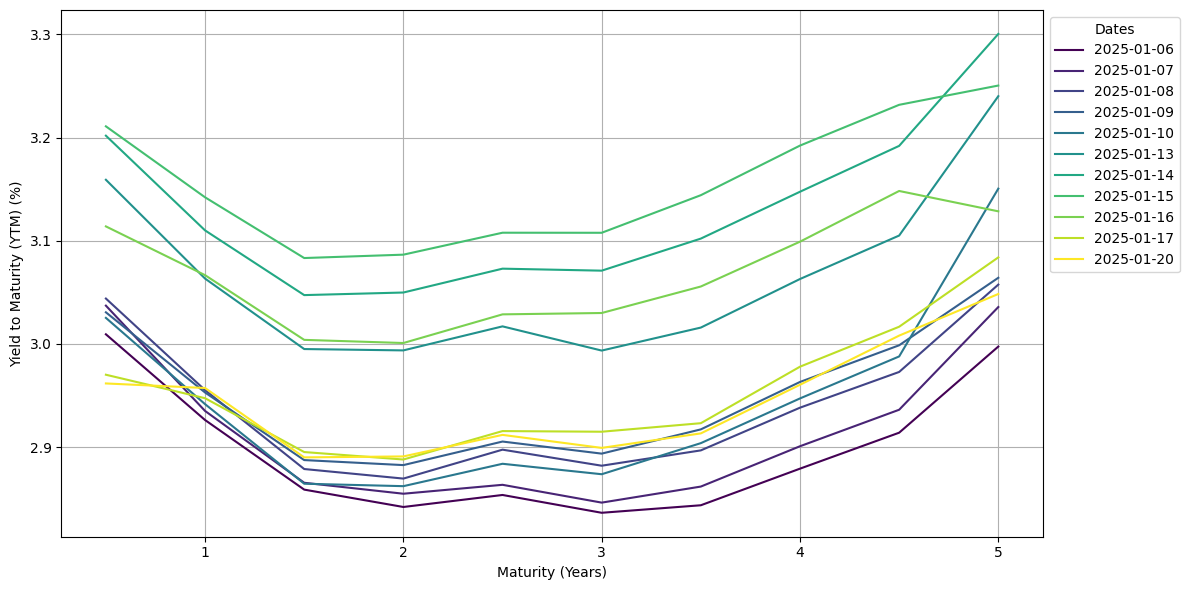

In [57]:
plot_ytm(filtered_df_yields, [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

# Plot spot rate curves

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)
C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True

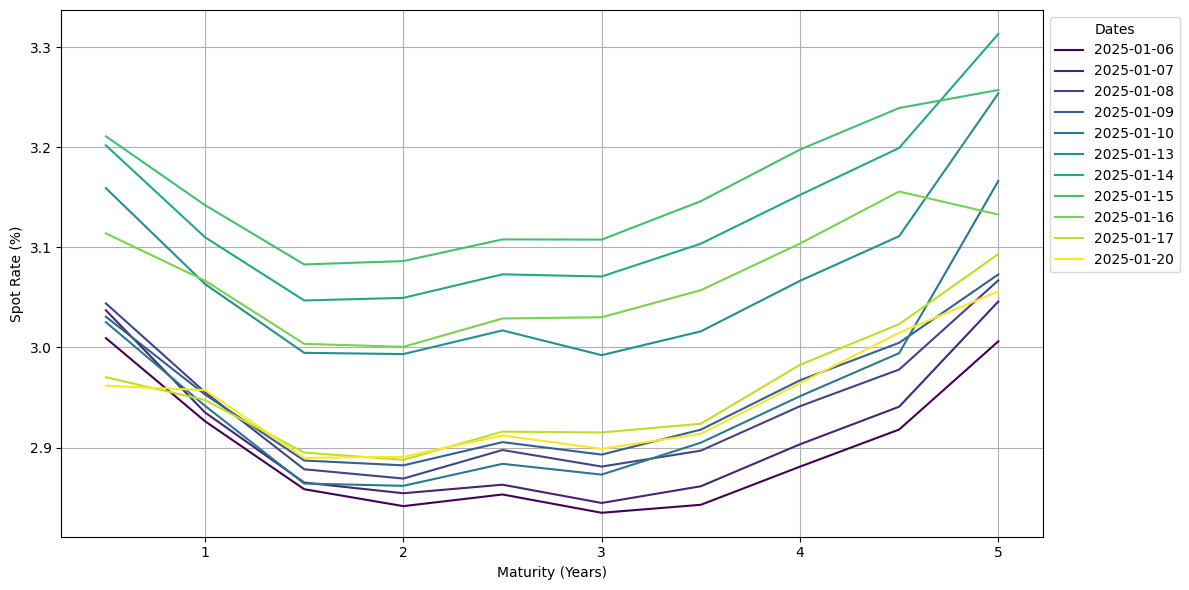

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)


,date,maturity_years,spot
0,2025-01-06,0.5,0.030093
1,2025-01-06,1.0,0.029263
2,2025-01-06,1.5,0.028584
3,2025-01-06,2.0,0.028415
4,2025-01-06,2.5,0.028532
5,2025-01-06,3.0,0.028349
6,2025-01-06,3.5,0.028429
7,2025-01-06,4.0,0.028809
8,2025-01-06,4.5,0.029180
9,2025-01-06,5.0,0.030061


In [58]:
def compute_spot_rate(data,date):
    # grab data on date
    bonds = data[data['date'] == date].sort_values('Maturity Date')
    result = pd.DataFrame(columns=['date', 'Maturity Date', 'spot'])
    
    for _, bond in bonds.iterrows():
        cur_date = bond['date']
        maturity_date = bond['Maturity Date']
        #print("Calculating for", maturity_date)
        clean_price = bond['midpoint']
        cpn = bond['Coupon']
        face_value =100
        issue_date = bond['Issue Date']

        # get prev coupon date
        last_coupon_date = get_last_cpn_date(cur_date, maturity_date, issue_date)

        #  dirty price calculation
        accrued_interest = calculate_accrued_interest(last_coupon_date, cur_date, cpn * face_value)
        dirty_price = clean_price + accrued_interest

        # get future coupon payment dates
        coupon_dates = generate_coupon_dates(cur_date, maturity_date)
        
        if len(coupon_dates) == 1:  # treat as zero coupon bond
            time_to_maturity = (maturity_date - cur_date).days / 365.0
            cash_flows = [(cpn / 2) * face_value] * (len(coupon_dates) - 1) + [face_value + (cpn / 2) * face_value]
            
            spot_rate = -np.log(dirty_price / cash_flows[-1]) / time_to_maturity

        else:  # bootstrap
            cash_flows = [(cpn / 2) * face_value] * (len(coupon_dates) - 1) + [face_value + (cpn / 2) * face_value]
            time_periods = [(date - cur_date).days / 365.0 for date in coupon_dates]

            # use the previously calculated spot rates
            discounted_cpn = 0
            for i, (cf, t) in enumerate(zip(cash_flows[:-1], time_periods[:-1])):
                known_spot = result[result['Maturity Date'] == coupon_dates[i]]['spot']
                if not known_spot.empty:
                    discounted_cpn += cf * np.exp(-known_spot.values[0] * t)
                if known_spot.empty:
                    # if previous spot rates not known, we assign np.nan for spot rate
                    discounted_cpn = np.nan
                    
            # final cf, solve for spot rate
            remaining_value = dirty_price - discounted_cpn
            final_cashflow = cash_flows[-1]
            time_to_last_payment = time_periods[-1]

            if remaining_value > 0:
                spot_rate = -np.log(remaining_value / final_cashflow) / time_to_last_payment
            else:
                spot_rate = np.nan
    
        result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)
    
    return result


def generate_interpolated_spot_curve(date, years, data):
    
    spot_rate_data = compute_spot_rate(data, date)
    spot_rate_data['maturity_years'] = (spot_rate_data['Maturity Date'] - date).dt.days / 365
    spot_rate_data = spot_rate_data.sort_values('maturity_years').dropna(subset=['spot'])

    result = pd.DataFrame({'date':  len(years) * [date], 'maturity_years': years})

    interpolated_spots = np.interp(
        years,
        spot_rate_data['maturity_years'],
        spot_rate_data['spot'],
        left=np.nan,
        right=np.nan
    )
    result['spot'] = interpolated_spots

    return result

def plot_spot(data, years):
    # get all dates
    unique_dates = data['date'].dropna().unique()

    colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))
    
    
    plt.figure(figsize=(12, 6))
    
    # loop through each date to get spot rates
    for i, date in enumerate(sorted(unique_dates)):
        interpolated_curve = generate_interpolated_spot_curve(date, years, data)
        plt.plot(
            interpolated_curve['maturity_years'], 
            100*interpolated_curve['spot'], 
            label=pd.to_datetime(date).strftime('%Y-%m-%d'), 
            color=colors[i]
        )
    
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Spot Rate (%)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dates')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#compute_spot_rate(filtered_df_yields, datetime(2025,1,20))

generate_interpolated_spot_curve(datetime(2025,1,20), [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], filtered_df_yields)
#filtered_df_yields[filtered_df_yields['date'] == datetime(2025,1,20)]

plot_spot(filtered_df_yields, [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

generate_interpolated_spot_curve(datetime(2025,1,6), [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], filtered_df_yields)

In [37]:
filtered_df_yields[filtered_df_yields['date'] == datetime(2025,1,10)].sort_values('Maturity Date')

,hyperlink,date,Yield,Bid,Ask,ISIN,Name,Coupon,Issue Date,Maturity Date,midpoint,ytm
173,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0326,99.73,99.75,CA135087K528,CAN 1.25 Mar25,0.0125,2019-10-11,2025-03-01,99.740,0.031726
174,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0303,98.39,98.47,CA135087K940,CAN 0.50 Sep25,0.0050,2020-04-03,2025-09-01,98.430,0.029681
186,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0297,96.99,97.01,CA135087L518,CAN 0.25 Mar26,0.0025,2020-10-09,2026-03-01,97.000,0.029317
180,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0288,97.03,97.05,CA135087L930,CAN 1.00 Sep26,0.0100,2021-04-16,2026-09-01,97.040,0.028386
473,https://markets.businessinsider.com/bonds/cana...,2025-01-10,NaN,96.61,96.64,CA135087M847,CAN 1.25 Mar27,0.0125,2021-10-15,2027-03-01,96.625,0.028713
183,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0292,99.58,99.61,CA135087N837,CAN 2.75 Sep27,0.0275,2022-05-13,2027-09-01,99.595,0.028889
204,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0292,101.71,101.94,CA135087P576,CAN 3.50 Mar28,0.0350,2022-10-21,2028-03-01,101.825,0.028680
205,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0297,100.93,101.18,CA135087Q491,CAN 3.25 Sep28,0.0325,2023-04-21,2028-09-01,101.055,0.029183
207,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0299,103.88,104.01,CA135087Q988,CAN 4.00 Mar29,0.0400,2023-10-13,2029-03-01,103.945,0.029586
210,https://markets.businessinsider.com/bonds/cana...,2025-01-10,0.0304,101.98,102.11,CA135087R895,CAN 3.50 Sep29,0.0350,2024-04-08,2029-09-01,102.045,0.029997


# Plot forward rate curves

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)
C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True

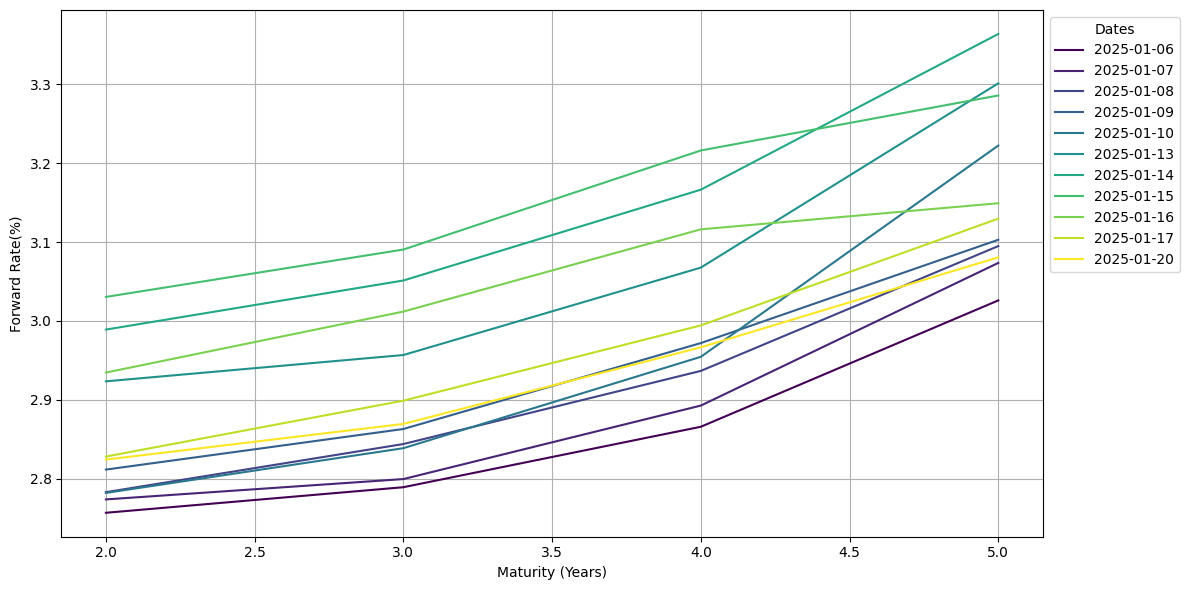

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\1895346661.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)


,date,forward_years,maturity_years,forward_rate
0,2025-01-06,1,2,0.027568
1,2025-01-06,1,3,0.027892
2,2025-01-06,1,4,0.028658
3,2025-01-06,1,5,0.030260


In [59]:
def calculate_forward_rate(date, t1, t2, data):
    t_values = sorted(set([t1] + t2))  # get all dates
    filtered_data = data[data['date'] == date]
    
    spot_curve = generate_interpolated_spot_curve(date, t_values, filtered_data) # calculate spot rates
    spot_curve = spot_curve.dropna(subset=['spot'])
    
    t1_spot = spot_curve[spot_curve['maturity_years'] == t1]['spot'].values[0]
    
    results = []
    # loop throuhg each date to get the spot rates
    for t in t2:
        if t <= t1:
            continue
        t2_spot = spot_curve[spot_curve['maturity_years'] == t]['spot'].values[0]
        forward_rate = (t2_spot * t - t1_spot * t1) / (t - t1)  
        results.append({'date': date, 'forward_years': t1, 'maturity_years': t, 'forward_rate': forward_rate})
    
    return pd.DataFrame(results)


def plot_forward(data, t1, years):
    # grab all dates
    unique_dates = data['date'].dropna().unique()
    
    colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))
    
    plt.figure(figsize=(12, 6))
    
    # loop through each date and plot forward curve
    for i, date in enumerate(sorted(unique_dates)):
        forward_curve = calculate_forward_rate(date, t1, years, data)
        
        plt.plot(
            forward_curve['maturity_years'], 
            100*forward_curve['forward_rate'], 
            label=pd.to_datetime(date).strftime('%Y-%m-%d'), 
            color=colors[i]
        )
    
 
    plt.xlabel("Maturity (Years)")
    plt.ylabel("Forward Rate(%)")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Dates')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

calculate_forward_rate(datetime(2025,1,10),1, [2,3,4,5], filtered_df_yields)
calculate_forward_rate(datetime(2025,1,20),1, [2,3,4,5], filtered_df_yields)
plot_forward(filtered_df_yields, 1, [2,3,4,5])

calculate_forward_rate(datetime(2025,1,6),1, [2,3,4,5], filtered_df_yields)

# Calculate covariance matrices and eigendecomposition

In [43]:
def compute_cov_ytm(data, years):

    # grab all dates from the data
    unique_dates = sorted(data['date'].dropna().unique())


    ytm_table = pd.DataFrame(
        index=pd.MultiIndex.from_product([unique_dates, years], names=["date", "maturity_years"]),
        columns=["ytm"]
    )

    # add to YTM table with interpolated YTMs
    for date in unique_dates:
        interpolated_curve = generate_interpolated_ytm_curve(date, years, data)
        for _, row in interpolated_curve.iterrows():
            ytm_table.loc[(date, row['maturity_years']), "ytm"] = row['ytm']

    ytm_table = ytm_table.reset_index()
    
    # shift the next rate in
    ytm_table['next_ytm'] = ytm_table.groupby('maturity_years')['ytm'].shift(-1)
    ytm_table['log_return'] = np.log( ytm_table['next_ytm'].astype('float')/ ytm_table['ytm'].astype('float'))

    log_returns_table = ytm_table.pivot(index='date', columns='maturity_years', values='log_return')
    log_returns_table = log_returns_table.dropna()

    # compute pairwise covariances
    cov_matrix = log_returns_table.cov()

    return cov_matrix



def compute_cov_forward(data, years, t1):
    unique_dates = sorted(data['date'].dropna().unique())

    
    forward_table = pd.DataFrame(
        index=pd.MultiIndex.from_product([unique_dates, years], names=["date", "maturity_years"]),
        columns=["forward_rate"]
    )

    
    for date in unique_dates:
        forward_rates = calculate_forward_rate(date, t1, years, data)  # Get all forward rates for this date
        
        for _, row in forward_rates.iterrows():
            forward_table.loc[(date, row['maturity_years']), "forward_rate"] = row['forward_rate']

    
    forward_table = forward_table.reset_index()
    
    # shift the next rate in
    forward_table['next_forward_rate'] = forward_table.groupby('maturity_years')['forward_rate'].shift(-1)
    forward_table['log_return'] = np.log(
        forward_table['next_forward_rate'].astype('float') / forward_table['forward_rate'].astype('float')
    )
    

    log_returns_table = forward_table.pivot(index='date', columns='maturity_years', values='log_return')
    log_returns_table = log_returns_table.dropna()

    
    cov_matrix = log_returns_table.cov()

    return cov_matrix



In [44]:


cov_matrix_ytm = compute_cov_ytm(filtered_df_yields, [1,2,3,4,5])

cov_matrix_forward = compute_cov_forward(filtered_df_yields, [2,3,4,5],1)

print("YTM Covariance Matrix")
print(cov_matrix_ytm)

print("Forward Rates Covariance Matrix")
print(cov_matrix_forward)

C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\376090643.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)
C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\376090643.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)


YTM Covariance Matrix
maturity_years         1         2         3         4         5
maturity_years                                                  
1               0.000468  0.000498  0.000488  0.000499  0.000298
2               0.000498  0.000540  0.000528  0.000543  0.000323
3               0.000488  0.000528  0.000535  0.000551  0.000326
4               0.000499  0.000543  0.000551  0.000574  0.000350
5               0.000298  0.000323  0.000326  0.000350  0.000458
Forward Rates Covariance Matrix
maturity_years         2         3         4         5
maturity_years                                        
2               0.000639  0.000591  0.000610  0.000290
3               0.000591  0.000594  0.000607  0.000287
4               0.000610  0.000607  0.000634  0.000319
5               0.000290  0.000287  0.000319  0.000586


C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\376090643.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)
C:\Users\Danie\AppData\Local\Temp\ipykernel_17308\376090643.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result,pd.DataFrame([{'date': cur_date, 'Maturity Date': maturity_date, 'spot': spot_rate}]) ], ignore_index = True)


In [51]:
# YTM

w,v = eig(cov_matrix_ytm)
print("YTM Cov Matrix 1st Eigenvalue: ")
print(w[0])
print("YTM Cov Matrix 1st Eigenvector: ", v[:,0])
print("YTM Cov Matrix Eigenvalues: ")
print(w)
print("YTM Variance Explained by Eigenvector: ")
print(w/np.sum(w))

# forward rate
w,v = eig(cov_matrix_forward)
print("Forward Rates Cov Matrix 1st Eigenvalue: ")
print(w[0])
print("Forward Rates Cov Matrix 1st Eigenvector: ", v[:,0])
print("Forward Rates Cov Matrix Eigenvalues: ")
print(w)
print("Forward Rates Variance Explained by Eigenvector: ")
print(w/np.sum(w))

YTM Cov Matrix 1st Eigenvalue: 
0.0023131219662424927
YTM Cov Matrix 1st Eigenvector:  [-0.44112839 -0.47672381 -0.4757527  -0.49262633 -0.33033139]
YTM Cov Matrix Eigenvalues: 
[2.31312197e-03 2.31540032e-04 2.38721894e-05 3.86926927e-06
 2.06088192e-06]
YTM Variance Explained by Eigenvector: 
[8.98486699e-01 8.99371679e-02 9.27268209e-03 1.50294149e-03
 8.00509020e-04]
Forward Rates Cov Matrix 1st Eigenvalue: 
0.002015402790032671
Forward Rates Cov Matrix 1st Eigenvector:  [-0.54468562 -0.53104282 -0.55256291 -0.3405662 ]
Forward Rates Cov Matrix Eigenvalues: 
[2.01540279e-03 3.99342506e-04 3.20096197e-05 5.66480390e-06]
Forward Rates Variance Explained by Eigenvector: 
[0.82180174 0.16283612 0.01305226 0.00230988]
